# Linear Regression and Neural Network models
## Step by step plan:

Data ingestion<br>

Data wrangling and feature engineering
- Outlier removal<br>
- Tokenization and cleanup of job titles<br>
- Creation of dummies for all categorical variables<br>

*Train test split*<br>

Post split wrangling<br>
- Feature selection and database cleanup<br>
- Independent variable normalization<br>

### Model creation and evaluation
- Parameter evaluation<br>
- Actual vs predicted target variable analysis<br>
- Residuals analysis<br>

### Created models:
- One linear model<br>
- One linear model using exclusively significant independent variables<br>
- One neural network model<br>
- One linear model using PCA (some exploratory analysis is done for PCA results)<br>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from math import ceil, floor
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.stattools import durbin_watson
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy.stats import boxcox, normaltest, kstest, pearsonr
from scipy.special import inv_boxcox

In [2]:
sns.set() # makes all charts look better by default

## Data Ingestion

In [3]:
aijobs = pd.read_csv(r'https://ai-jobs.net/salaries/download/salaries.csv')
# Last accessed at 2024-03-23

In [4]:
aijobs # first look at the data

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2024,MI,FT,Data Engineer,120000,CHF,136363,CH,50,CH,L
1,2024,SE,PT,Data Architect,212000,USD,212000,US,0,US,M
2,2024,SE,PT,Data Architect,93300,USD,93300,US,0,US,M
3,2024,MI,FT,Data Product Owner,321830,USD,321830,US,0,US,M
4,2024,MI,FT,Data Product Owner,124690,USD,124690,US,0,US,M
...,...,...,...,...,...,...,...,...,...,...,...
14796,2020,SE,FT,Data Scientist,412000,USD,412000,US,100,US,L
14797,2021,MI,FT,Principal Data Scientist,151000,USD,151000,US,100,US,L
14798,2020,EN,FT,Data Scientist,105000,USD,105000,US,100,US,S
14799,2020,EN,CT,Business Data Analyst,100000,USD,100000,US,100,US,L


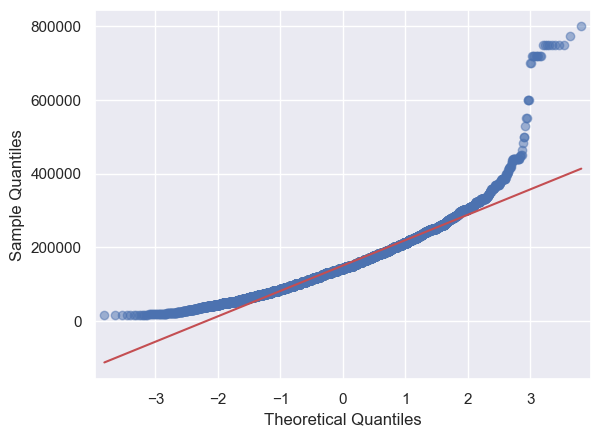

In [5]:
sm.qqplot(aijobs['salary_in_usd'], line='s', alpha=0.5)
plt.show()

# Common data wrangling
These steps would be equally done for train and test bases with no population or sampled information, only individual ones, so no data leakage will occur if done now.

### Outlier removal

In [6]:
# The first outliers are extremely out of touch with the remainder of the database.
# They will skew the results too much and must be removed.
# According to Hair, from 2.5 to 4 standards deviations might be used to remove outliers.
# Visually, 4 deviations cover the worst cases.

mean = aijobs['salary_in_usd'].mean()
std = mean = aijobs['salary_in_usd'].std()
outmax = mean + 4 * std
print(outmax)
outliers = aijobs[aijobs['salary_in_usd'] > outmax].index
print(outliers)

aijobs.drop(outliers, inplace=True)
aijobs.reset_index(drop=True, inplace=True)
aijobs.sort_values('salary_in_usd', ascending=False).head()

345187.57544700877
Index([  153,   157,   320,   410,   428,   455,   457,   569,   593,   617,
       ...
       13095, 13438, 13453, 13632, 14526, 14531, 14583, 14728, 14793, 14796],
      dtype='int64', length=143)


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
586,2024,SE,FT,Research Scientist,345000,USD,345000,US,0,US,M
9909,2023,SE,FT,Research Scientist,345000,USD,345000,US,0,US,M
11005,2023,SE,FT,Computer Vision Engineer,342810,USD,342810,US,0,US,M
2553,2024,SE,FT,Data Analytics Lead,342400,USD,342400,US,0,US,M
11103,2023,SE,FT,Machine Learning Engineer,342300,USD,342300,US,0,US,L


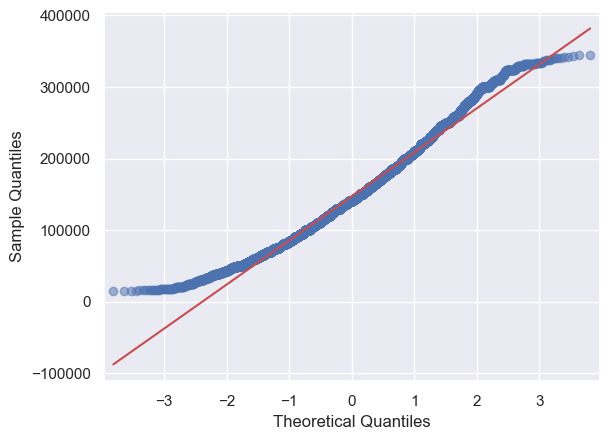

In [7]:
sm.qqplot(aijobs['salary_in_usd'], line='s', alpha=0.5)
plt.show()

## Feature Engineering

In [8]:
# There is no value in local currency salaries as they're not scaled.
# Salary in USD conveys the same useful information in a scaled manner.
aijobs.drop('salary', axis=1, inplace=True)

In [9]:
# An interesting variable to research
aijobs['work_abroad'] = aijobs['employee_residence'] != aijobs['company_location']
aijobs['work_abroad'] = aijobs['work_abroad'].astype(int)
aijobs.tail(10)

,work_year,experience_level,employment_type,job_title,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,work_abroad
14648,2020,MI,FT,Data Engineer,USD,130800,ES,100,US,M,1
14649,2020,SE,FT,Machine Learning Engineer,EUR,45618,HR,100,HR,S,0
14650,2021,SE,FT,Director of Data Science,USD,168000,JP,0,JP,S,0
14651,2021,MI,FT,Data Scientist,SGD,119059,SG,100,IL,M,1
14652,2021,MI,FT,Data Engineer,EUR,28369,MT,50,MT,L,0
14653,2021,SE,FT,Data Specialist,USD,165000,US,100,US,L,0
14654,2021,MI,FT,Principal Data Scientist,USD,151000,US,100,US,L,0
14655,2020,EN,FT,Data Scientist,USD,105000,US,100,US,S,0
14656,2020,EN,CT,Business Data Analyst,USD,100000,US,100,US,L,0
14657,2021,SE,FT,Data Science Manager,INR,94665,IN,50,IN,L,0


In [10]:
# remote_ratio is categorical; the correct way to interpret those numbers is:
#   0 == On Site (less than 20% remote)
#  50 == Partially remote/hybird
# 100 == Fully remote (more than 80% remote)
# therefore using it as numerical would be creating a spurious relationship.
# It has to be dummified and will be switched for easier interpretation.

aijobs.loc[aijobs['remote_ratio'] == 0, 'remote_ratio'] = 'On_Site'
aijobs.loc[aijobs['remote_ratio'] == 50, 'remote_ratio'] = 'Hybrid'
aijobs.loc[aijobs['remote_ratio'] == 100, 'remote_ratio'] = 'Remote'

aijobs['remote_ratio']

0         Hybrid
1        On_Site
2        On_Site
3        On_Site
4        On_Site
          ...   
14653     Remote
14654     Remote
14655     Remote
14656     Remote
14657     Hybrid
Name: remote_ratio, Length: 14658, dtype: object

In [11]:
# Categorical columns will receive appropriate treatment
categorical_columns = ['experience_level', 'employment_type', 'salary_currency', 'employee_residence', 'remote_ratio', 
                       'company_location', 'company_size']

In [12]:
# Quick look at job titles. This will receive a quick NLP method for processing.
print(len(aijobs['job_title'].unique()), "different job titles \n")
print(aijobs['job_title'].unique())

150 different job titles 

['Data Engineer' 'Data Architect' 'Data Product Owner' 'MLOps Engineer'
 'Data Specialist' 'Data Manager' 'Analytics Engineer' 'Data Analyst'
 'Machine Learning Scientist' 'Business Intelligence Engineer'
 'Data Scientist' 'Business Intelligence Analyst' 'Data Science'
 'Data Analytics Manager' 'Encounter Data Management Professional'
 'Machine Learning Engineer' 'Research Scientist' 'Research Engineer'
 'AI Engineer' 'Data Modeler' 'Research Analyst' 'ML Engineer'
 'Data Science Consultant' 'Applied Scientist' 'BI Analyst'
 'Data Integration Engineer' 'Data Integration Specialist'
 'Machine Learning Operations Engineer'
 'Machine Learning Infrastructure Engineer' 'Data Developer'
 'Business Intelligence' 'CRM Data Analyst' 'ETL Developer'
 'Business Intelligence Manager' 'Data Science Engineer' 'AI Architect'
 'Robotics Engineer' 'BI Developer' 'Head of Data' 'Data Science Manager'
 'Cloud Database Engineer' 'Data Operations Analyst'
 'Data Science Analyst' 

In [13]:
# Work on the terms contained in job titles.
terms = []
for title in aijobs['job_title'].unique():
    for word in title.split():
        terms.append(word)
terms = sorted(set(terms))
print(len(terms), "different terms in these titles \n")
print(terms)

80 different terms in these titles 

['&', 'AI', 'AWS', 'Admin', 'Analyst', 'Analytics', 'Applied', 'Architect', 'Associate', 'Autonomous', 'Azure', 'BI', 'Big', 'Biologist', 'Business', 'CRM', 'Cloud', 'Compliance', 'Computational', 'Computer', 'Consultant', 'Data', 'Database', 'Decision', 'Deep', 'DevOps', 'Developer', 'Director', 'ETL', 'Encounter', 'Engineer', 'Finance', 'Financial', 'Head', 'Infrastructure', 'Insight', 'Integration', 'Intelligence', 'Lead', 'Learning', 'ML', 'MLOps', 'Machine', 'Management', 'Manager', 'Managing', 'Marketing', 'Modeler', 'Modeller', 'NLP', 'Operations', 'Ops', 'Owner', 'Pipeline', 'Power', 'Practitioner', 'Principal', 'Product', 'Professional', 'Programmer', 'Prompt', 'Quality', 'Quantitative', 'Reporting', 'Research', 'Researcher', 'Robotics', 'Sales', 'Science', 'Scientist', 'Software', 'Specialist', 'Staff', 'Strategist', 'Strategy', 'Technician', 'Vehicle', 'Vision', 'Visualization', 'of']


In [14]:
stop_words = ['&', 'of', 'Data', 'Learning', 'Computational', 'Computer', 'Autonomous', 'Technician', 'Professional']
# Justification: '&', 'of' and 'Data' are too generic for this project.
# 'Learning' has two contexts: Machine Learning and Deep Learning, yet both "Machine" and "Deep" are unique to them,
# so there's nothing to be gained from adding it.
# "Autonomous Vehicle Technician" is a job title whose words are all unique, so a single one is enough.
# "Computational Biologist" shares the same issue.
# "Encounter Data Management Professional" is the only to use "Encounter" and "Professional".
# "Computer Vision" is present in more than one job, but all of them use this same sequence, so it's the same situation.

In [15]:
synonym_terms = ['ML','Machine','MLOps', 'Operations','Business','BI','Intelligence','AWS','Cloud','Azure','Modeller','Modeler',
                 'Engineering','Engineer','Financial','Finance','Researcher','Research','Science','Scientist',
                 'Strategy','Strategist','Management','Manager', 'Managing']

In [16]:
# this uses the same pressupositions as above, but some words will mean the same thing.
synonyms = {'Machine': 'Machine|ML|MLOps',      # ML is short for Machine Learning
            'Operations':'MLOps|Operations',    # Ops is short for Operations
            'Intelligence':'Intelligence|BI',   # BI is short for Business Intelligence (Intelligence is exclusive to BI)
            'Business':'Business|BI',           # For consistency (Business is not exclusive to BI)
            'Cloud':'Cloud|AWS|Azure',          # There is a single instance for AWS and for Azure; both specific cloud tools
            'Modeler':'Modeler|Modeller',       # Typo
            'Engineer':'Engineer|Engineering',
            'Finance':'Finance|Financial',
            'Research':'Research|Researcher',
            'Scientist':'Scientist|Science',
            'Strategist':'Strategist|Strategy',
            'Manager':'Management|Manager|Managing'}
# Note: Analyst and Analytics in this context will mean different things.

In [17]:
clean_terms = terms.copy()                                                   # copy method to keep the original list
[clean_terms.remove(term) for term in stop_words if term in clean_terms]     # remove stop words
[clean_terms.remove(term) for term in synonym_terms if term in clean_terms]  # synonyms will be processed differently
print(len(clean_terms), "terms after cleaning\n", len(synonyms), "synonyms\n ", len(clean_terms)+len(synonyms), "total terms\n")
print(clean_terms)

47 terms after cleaning
 12 synonyms
  59 total terms

['AI', 'Admin', 'Analyst', 'Analytics', 'Applied', 'Architect', 'Associate', 'Big', 'Biologist', 'CRM', 'Compliance', 'Consultant', 'Database', 'Decision', 'Deep', 'DevOps', 'Developer', 'Director', 'ETL', 'Encounter', 'Head', 'Infrastructure', 'Insight', 'Integration', 'Lead', 'Marketing', 'NLP', 'Ops', 'Owner', 'Pipeline', 'Power', 'Practitioner', 'Principal', 'Product', 'Programmer', 'Prompt', 'Quality', 'Quantitative', 'Reporting', 'Robotics', 'Sales', 'Software', 'Specialist', 'Staff', 'Vehicle', 'Vision', 'Visualization']


In [18]:
# dummization for all chosen job keywords
for job_string in clean_terms:
    aijobs['job_name_' + job_string] = aijobs['job_title'].str.contains(job_string, case=False).astype(int)
for job_string in synonyms.keys():
    aijobs['job_name_' + job_string] = aijobs['job_title'].str.contains(f'{synonyms[job_string]}', case=False).astype(int)
aijobs.head()

,work_year,experience_level,employment_type,job_title,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,...,job_name_Intelligence,job_name_Business,job_name_Cloud,job_name_Modeler,job_name_Engineer,job_name_Finance,job_name_Research,job_name_Scientist,job_name_Strategist,job_name_Manager
0,2024,MI,FT,Data Engineer,CHF,136363,CH,Hybrid,CH,L,...,0,0,0,0,1,0,0,0,0,0
1,2024,SE,PT,Data Architect,USD,212000,US,On_Site,US,M,...,0,0,0,0,0,0,0,0,0,0
2,2024,SE,PT,Data Architect,USD,93300,US,On_Site,US,M,...,0,0,0,0,0,0,0,0,0,0
3,2024,MI,FT,Data Product Owner,USD,321830,US,On_Site,US,M,...,0,0,0,0,0,0,0,0,0,0
4,2024,MI,FT,Data Product Owner,USD,124690,US,On_Site,US,M,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# dummization for all other categorical columns
df_dummies = pd.get_dummies(aijobs[categorical_columns], dtype=int)
aijobs = pd.concat([aijobs, df_dummies], axis=1)
aijobs.head()

,work_year,experience_level,employment_type,job_title,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,...,company_location_SI,company_location_TH,company_location_TR,company_location_UA,company_location_US,company_location_VN,company_location_ZA,company_size_L,company_size_M,company_size_S
0,2024,MI,FT,Data Engineer,CHF,136363,CH,Hybrid,CH,L,...,0,0,0,0,0,0,0,1,0,0
1,2024,SE,PT,Data Architect,USD,212000,US,On_Site,US,M,...,0,0,0,0,1,0,0,0,1,0
2,2024,SE,PT,Data Architect,USD,93300,US,On_Site,US,M,...,0,0,0,0,1,0,0,0,1,0
3,2024,MI,FT,Data Product Owner,USD,321830,US,On_Site,US,M,...,0,0,0,0,1,0,0,0,1,0
4,2024,MI,FT,Data Product Owner,USD,124690,US,On_Site,US,M,...,0,0,0,0,1,0,0,0,1,0


In [20]:
aijobs[categorical_columns].describe().loc['unique']

experience_level       4
employment_type        4
salary_currency       22
employee_residence    87
remote_ratio           3
company_location      77
company_size           3
Name: unique, dtype: object

In [21]:
# To establish the features, categorical columns that are not dummies will need to be removed. Target variable too.

X_vars = aijobs.columns.tolist()
[X_vars.remove(col) for col in categorical_columns if col in X_vars]
X_vars.remove('job_title')
X_vars.remove('salary_in_usd')

In [22]:
# Comprehensive dummies will need one instance removed.
# They could be picked by hand, but the algorithm below selects the most popular for deletion.

c_dummies = aijobs[['experience_level_EN', 'experience_level_MI', 'experience_level_SE', 'experience_level_EX']].sum()
X_vars.remove(c_dummies[c_dummies == c_dummies.max()].index)

c_dummies = aijobs[['employment_type_FL', 'employment_type_PT', 'employment_type_CT', 'employment_type_FT']].sum()
X_vars.remove(c_dummies[c_dummies == c_dummies.max()].index)

c_dummies = aijobs[['remote_ratio_Remote', 'remote_ratio_Hybrid', 'remote_ratio_On_Site']].sum()
X_vars.remove(c_dummies[c_dummies == c_dummies.max()].index)

c_dummies = aijobs[['company_size_S', 'company_size_M', 'company_size_L']].sum()
X_vars.remove(c_dummies[c_dummies == c_dummies.max()].index)

# These larger dummies will be implied in the intercept.
X_vars.remove('salary_currency_USD')
X_vars.remove('employee_residence_US')
X_vars.remove('company_location_US')

print(X_vars)

['work_year', 'work_abroad', 'job_name_AI', 'job_name_Admin', 'job_name_Analyst', 'job_name_Analytics', 'job_name_Applied', 'job_name_Architect', 'job_name_Associate', 'job_name_Big', 'job_name_Biologist', 'job_name_CRM', 'job_name_Compliance', 'job_name_Consultant', 'job_name_Database', 'job_name_Decision', 'job_name_Deep', 'job_name_DevOps', 'job_name_Developer', 'job_name_Director', 'job_name_ETL', 'job_name_Encounter', 'job_name_Head', 'job_name_Infrastructure', 'job_name_Insight', 'job_name_Integration', 'job_name_Lead', 'job_name_Marketing', 'job_name_NLP', 'job_name_Ops', 'job_name_Owner', 'job_name_Pipeline', 'job_name_Power', 'job_name_Practitioner', 'job_name_Principal', 'job_name_Product', 'job_name_Programmer', 'job_name_Prompt', 'job_name_Quality', 'job_name_Quantitative', 'job_name_Reporting', 'job_name_Robotics', 'job_name_Sales', 'job_name_Software', 'job_name_Specialist', 'job_name_Staff', 'job_name_Vehicle', 'job_name_Vision', 'job_name_Visualization', 'job_name_Machi

# Splitting and working the data before model fit

In [23]:
X_train, X_test, y_train, y_test = train_test_split(aijobs[X_vars], aijobs['salary_in_usd'], test_size=0.25, random_state=42)

In [24]:
X_train

,work_year,work_abroad,job_name_AI,job_name_Admin,job_name_Analyst,job_name_Analytics,job_name_Applied,job_name_Architect,job_name_Associate,job_name_Big,...,company_location_SE,company_location_SG,company_location_SI,company_location_TH,company_location_TR,company_location_UA,company_location_VN,company_location_ZA,company_size_L,company_size_S
8126,2023,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11729,2023,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1698,2024,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
761,2024,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8772,2023,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5191,2023,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13418,2022,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5390,2023,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
860,2024,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
# To delete columns with too few instances in order to avoid overfitting
# Hair says 5 entries is a minimum threshold; any dummy with less than 5 examples is too prone to overfitting.

def del_vars(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, printing=False):
    """
    This function deletes all columns in training base that have too few instances and will result in overfitting
    It also deletes every row that had an instance in such columns in order to prevent assumptions implied in the intecept
    As these variables are rendered unworkable, they are also deleted from test base (no information leak happens)
    Every row removed from independent variables bases (X) is also removed from the dependent variable array (y).
    """
    
    if printing == True:
        print("Before:", X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    deletions = 1 #just to enter the loop
    train_dropped = []
    while deletions > 0:
        deletions = X_train.shape[0] # store the dataframe size for later comparison
        X_sum = X_train.sum()
        exclusion_list = X_sum[X_sum < 5].index # create the exclusion column list

        # deleting all rows with any positive value in those variables
        X_delete = X_train[exclusion_list].sum(axis=1)
        rows_to_delete = X_delete[X_delete != 0]
        X_train.drop(rows_to_delete.index, inplace=True)
        
        [train_dropped.append(item) for item in rows_to_delete.index] # list all deleted rows for later consistency wity y array
        deletions = deletions - X_train.shape[0] # difference from previous dataframe size
        if printing == True:
            print('Rows deleted:', deletions) # deleted rows in this loop
            print('Columns dropped:', len(exclusion_list)) # cumulative columns to be deleted
        # loop until there are no more deleted rows
        
    X_train.drop(exclusion_list, axis=1, inplace=True) # dropping columns from train base now
    
    test_deletion = X_test[exclusion_list].sum(axis=1) # filter a dataframe by select all exclusion rows and their sum
    test_dropped = test_deletion[test_deletion > 0].index # finding all rows with a positive value on any of those dummies
    X_test.drop(test_dropped, inplace=True) # dropping unworkable test rows
    X_test.drop(exclusion_list, axis=1, inplace=True) # dropping columns from test base
    
    # shaping dependent variable arrays to match independent variables dataframes
    y_train.drop(train_dropped, inplace=True)
    y_test.drop(test_dropped, inplace=True)
    if printing == True:
        print("After:", X_train.shape, y_train.shape, X_test.shape, y_test.shape)

In [26]:
del_vars(printing=True)

Before: (10993, 254) (10993,) (3665, 254) (3665,)
Rows deleted: 140
Columns dropped: 131
Rows deleted: 20
Columns dropped: 141
Rows deleted: 2
Columns dropped: 142
Rows deleted: 0
Columns dropped: 142
After: (10831, 112) (10831,) (3596, 112) (3596,)


## Box-Cox transformation

Best Lambda Value: 0.5369


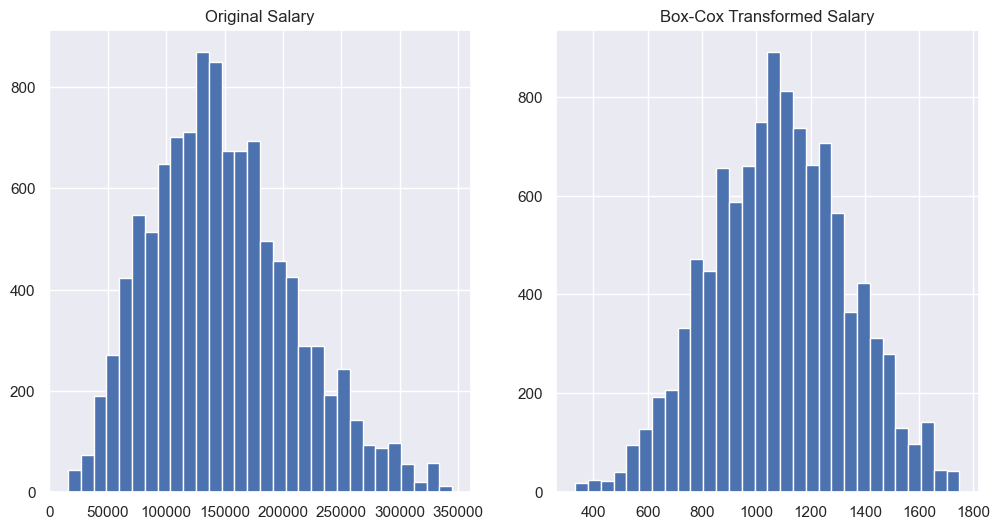

Normal test: NormaltestResult(statistic=39.41319703948477, pvalue=2.7639679690149327e-09)
Kolmogorov-Smirnov test: KstestResult(statistic=1.0, pvalue=0.0, statistic_location=332.5980925633564, statistic_sign=-1)


In [27]:
# fit the lambda and transform the train dependent variable
y_train_original = y_train.copy()
y_train_vals, lmbda = boxcox(y_train)
print(f'Best Lambda Value: {lmbda:.4f}')
y_train = pd.Series(y_train_vals, index=y_train.index, name='transformed_salary')

# transform the test dependent variable

y_test_original = y_test.copy()
y_test_vals = boxcox(y_test, lmbda)
y_test = pd.Series(y_test_vals, index=y_test.index, name='transformed_salary')

# plot

plt.figure(figsize=(12, 6))

# Original
plt.subplot(1, 2, 1)
plt.hist(y_train_original, bins=30)
plt.title('Original Salary')

# Transformed
plt.subplot(1, 2, 2)
plt.hist(y_train, bins=30)
plt.title('Box-Cox Transformed Salary')

plt.show()

print('Normal test:', normaltest(y_train))
print('Kolmogorov-Smirnov test:', kstest(y_train, "norm"))

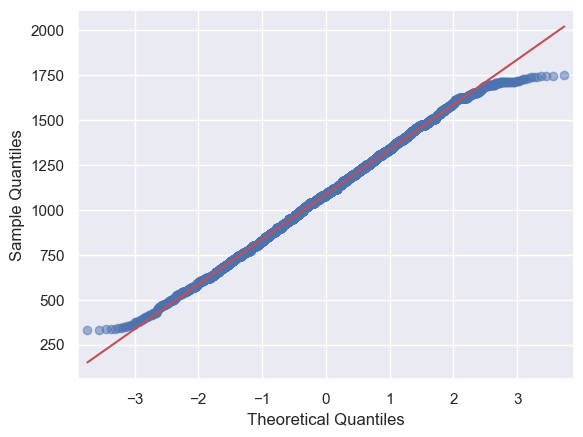

In [28]:
sm.qqplot(y_train, line='s', alpha=0.5)
plt.show()

In [29]:
y_test.describe()

count    3596.000000
mean     1087.816699
std       248.445245
min       342.212740
25%       922.394471
50%      1084.175897
75%      1254.112865
max      1748.580513
Name: transformed_salary, dtype: float64

# Starting the Model

In [30]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

In [31]:
# Create a model and displaying the summary
OLS_model = sm.OLS(y_train, X_train).fit()
OLS_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     transformed_salary   R-squared:                       0.435
Model:                            OLS   Adj. R-squared:                  0.429
Method:                 Least Squares   F-statistic:                     80.08
Date:                Sun, 24 Mar 2024   Prob (F-statistic):               0.00
Time:                        20:26:35   Log-Likelihood:                -72071.
No. Observations:               10831   AIC:                         1.443e+05
Df Residuals:                   10727   BIC:                         1.451e+05
Df Model:                         103                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -1.496e+04   5956.532     -2.512      0.012   -2.66e+04   -3287.985
work_year                   7.9138      2.944      2.688      0.007       2.143      13.684
work_abroad                 5.0841     60.716      0.084      0.933    -113.930     124.098
job_name_AI                86.9764     17.949      4.846      0.000      51.793     122.160
job_name_Analyst          -31.1267     16.035     -1.941      0.052     -62.558       0.305
job_name_Analytics         27.8954     10.518      2.652      0.008       7.278      48.513
job_name_Applied          116.9878     12.514      9.348      0.000      92.457     141.518
job_name_Architect        123.1742     19.129      6.439      0.000      85.677     160.671
job_name_Big               53.4941     67.596      0.791      0.429     -79.007     185.996
job_name_Consultant      -178.5597     23.083     -7.736      0.000    -223.807    -133.313
job_name_Database        -292.2266    140.560     -2.079      0.038    -567.750     -16.704
job_name_Decision          13.5822     33.576      0.405      0.686     -52.233      79.398
job_name_Deep             225.0140     52.766      4.264      0.000     121.583     328.445
job_name_Developer        -46.0194     22.810     -2.018      0.044     -90.731      -1.308
job_name_Director         152.8421     34.608      4.416      0.000      85.005     220.679
job_name_ETL               44.0549     44.710      0.985      0.324     -43.584     131.694
job_name_Head             261.5052     34.354      7.612      0.000     194.166     328.844
job_name_Infrastructure    21.5697     33.115      0.651      0.515     -43.343      86.482
job_name_Insight          -43.6528     60.637     -0.720      0.472    -162.512      75.207
job_name_Integration        9.6905     38.972      0.249      0.804     -66.702      86.083
job_name_Lead              90.0943     25.222      3.572      0.000      40.654     139.535
job_name_NLP               15.8432     68.567      0.231      0.817    -118.561     150.248
job_name_Ops              -25.6175     55.513     -0.461      0.644    -134.433      83.198
job_name_Owner            143.6612     93.795      1.532      0.126     -40.195     327.518
job_name_Practitioner    -124.7154     50.584     -2.466      0.014    -223.869     -25.562
job_name_Principal        127.1938     52.982      2.401      0.016      23.340     231.048
job_name_Product          100.2566     39.402      2.544      0.011      23.022     177.491
job_name_Prompt           124.1226     57.388      2.163      0.031      11.632     236.613
job_name_Quality         -125.8292     38.766     -3.246      0.001    -201.818     -49.840
job_name_Robotics         -28.9567     61.276     -0.473      0.637    -149.069      91.156
job_name_Software         111.0239     47.383  

In [32]:
pvalues = OLS_model.pvalues
print('Significant coefficients:', pvalues[pvalues <= 0.05].count())
print('Coefficients NOT significant:', pvalues[pvalues > 0.05].count(), '\n')
print(OLS_model.pvalues.sort_values().to_string())

Significant coefficients: 63
Coefficients NOT significant: 50 

experience_level_EN        3.360321e-147
experience_level_MI        6.331805e-133
job_name_Machine            1.715993e-99
salary_currency_GBP         7.354320e-34
job_name_Research           4.456259e-31
job_name_Applied            1.067377e-20
job_name_Scientist          1.275634e-17
experience_level_EX         1.715526e-15
job_name_Consultant         1.122164e-14
job_name_Head               2.921369e-14
job_name_Architect          1.253556e-10
job_name_Engineer           4.808494e-10
salary_currency_EUR         1.234263e-07
employee_residence_LV       5.109849e-07
company_location_LV         5.109849e-07
company_size_S              7.472853e-07
employee_residence_CO       1.176929e-06
company_location_CO         1.176929e-06
job_name_AI                 1.279294e-06
salary_currency_CAD         1.551190e-06
job_name_Director           1.013235e-05
job_name_Vision             1.599481e-05
job_name_Deep               2.0218

In [33]:
y_pred = OLS_model.predict(X_test)

In [34]:
comparison_OLS = y_pred.to_frame().join(y_test.to_frame()).join((y_pred - y_test).to_frame(), lsuffix='pred')
comparison_OLS.columns = ["predicted", "test_actuals", "difference"]
comparison_OLS.describe()

,predicted,test_actuals,difference
count,3596.000000,3596.000000,3596.000000
mean,1084.442902,1087.816699,-3.373798
std,162.543956,248.445245,192.325319
min,342.399986,342.212740,-783.993208
25%,1009.519000,922.394471,-131.222134
50%,1135.533191,1084.175897,6.576117
75%,1178.131991,1254.112865,132.446762
max,1541.638526,1748.580513,554.703518


In [35]:
# Design a function to create a scatter plot
def create_scatter(model_corr, y_pred, y_test=y_test, height=7):
    m, b = np.polyfit(y_test, y_pred, deg=1)
    R_2 = pearsonr(y_test, y_pred)
    llim = min(y_test.min(), y_pred.min())
    ulim = max(y_test.max(), y_pred.max())
    
    llim = floor(llim/100)*100
    ulim = ceil(ulim/100)*100

    print('Scatter plot of Predicted vs Actual values')

    g = sns.jointplot(x=y_test, y=y_pred, kind="reg", height=height, xlim=(llim, ulim), ylim=(llim, ulim), 
                      joint_kws={'scatter_kws':dict(alpha=0.2)}, line_kws=dict(color="r"))

    for i in range(ceil(llim/400)*400+200, ceil(ulim), 400):
        g.refline(x=i, y=i, linestyle=":", alpha=.5)

    plt.xlabel('Actual y test values')
    plt.ylabel('Predicted y values')

    plt.show()

    print(f'Model R squared: {model_corr:.4f}')
    print(f'Prediction R squared: {R_2[0]**2:.4f} p-value: {R_2[1]:.4f}')
    print(f'y = {m:.4f}x {b:+.1f}')

Scatter plot of Predicted vs Actual values


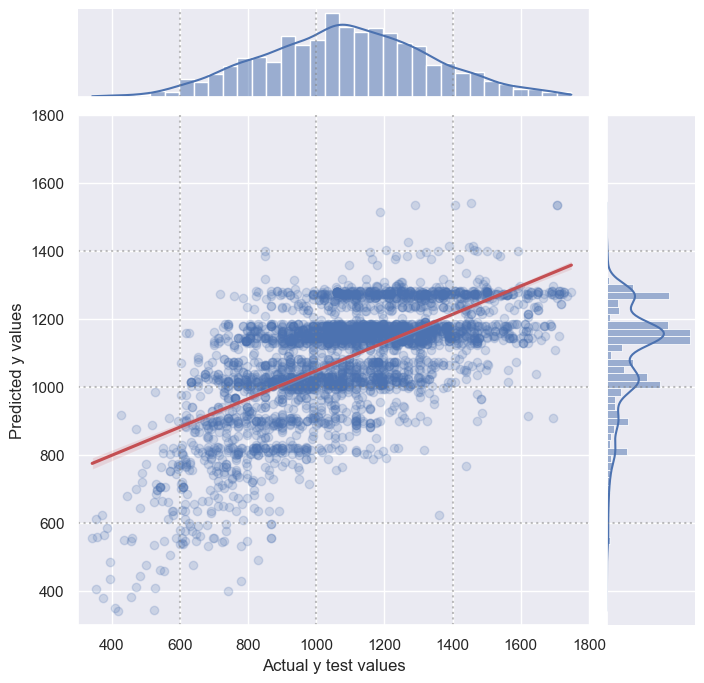

Model R squared: 0.4347
Prediction R squared: 0.4012 p-value: 0.0000
y = 0.4144x +633.7


In [36]:
create_scatter(y_pred=y_pred, model_corr=OLS_model.rsquared)

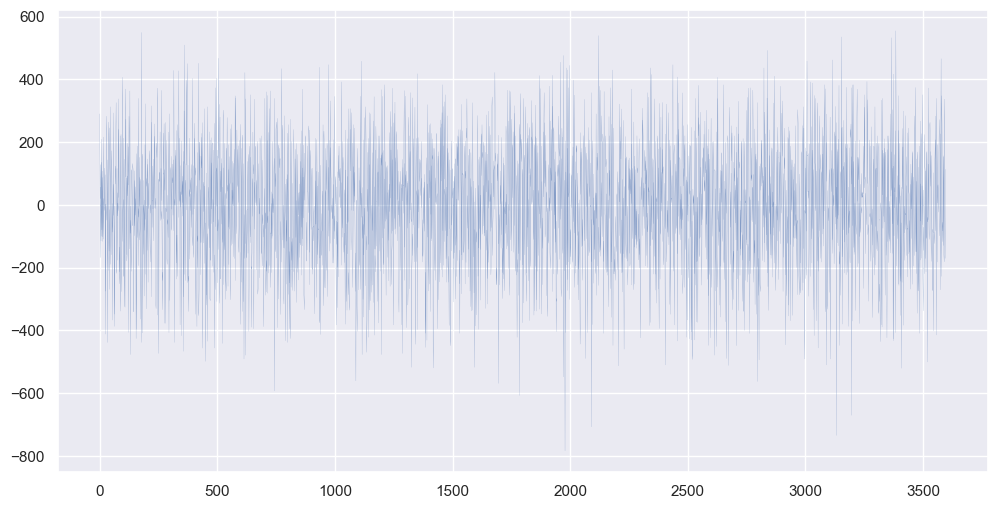

Residuals mean: -3.373798; Standard Deviation: 192.30
 Durbin Watson: 2.05


In [37]:
# Plotting the residuals
residuals_OLS = comparison_OLS.difference.values

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1,1,1)
ax.plot(residuals_OLS, linewidth=0.1)
plt.show()
print(f'Residuals mean: {residuals_OLS.mean():.6f}; Standard Deviation: {residuals_OLS.std():.2f}'
    f'\n Durbin Watson: {durbin_watson(residuals_OLS):.2f}')
# closer to 2 means no autocorrelation; 0 or 4 means autocorrelation

NormaltestResult(statistic=30.08818970111849, pvalue=2.9270667149619574e-07)
KstestResult(statistic=0.5071775257174551, pvalue=0.0, statistic_location=3.8776732035642, statistic_sign=-1)


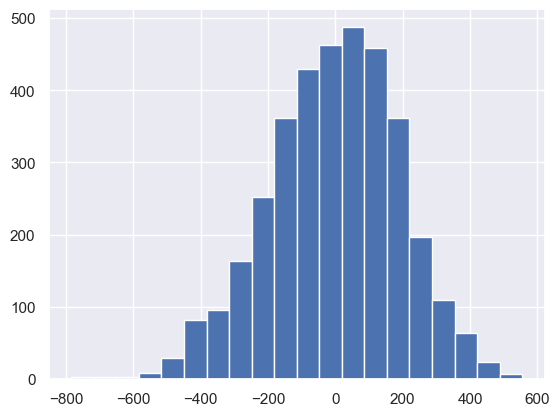

In [38]:
# tests and histogram to look at residuals' normality
print(normaltest(residuals_OLS))
print(kstest(residuals_OLS, "norm"))
plt.hist(residuals_OLS, bins=20)
plt.show()

## SIGNIFICANT ONLY

In [39]:
print('Intercept significance:', OLS_model.pvalues[OLS_model.pvalues.index == 'const'][0])

Intercept significance: 0.01201329043591988


In [40]:
X_train_step = X_train.copy()
X_test_step = X_test.copy()
y_train_step = y_train.copy()
y_test_step = y_test.copy()

X_train_step = sm.add_constant(X_train_step)
X_test_step = sm.add_constant(X_test_step)

In [41]:
# Create a model and displaying the summary

# A few variables look like they still have high p-values even in an isolated model.
# Loop until only significant variables are present
NOT_significant_vars = [1] # creation of a non empty list to enter the loop
while NOT_significant_vars != []:
    # The model is created, but a new one using only the previously resulting significant variables 
    # did not render a new model with all variables resulting significant.
    # A stepwise deletion for these variables will be done here until that happens.
    del_vars(X_train=X_train_step, X_test=X_test_step, y_train=y_train_step, y_test=y_test_step)
    OLS_model_step = sm.OLS(y_train_step, X_train_step).fit()
    y_pred_step = OLS_model_step.predict(X_test_step)

    # Bring all not significant variables into a single list
    NOT_significant_vars = OLS_model_step.pvalues[OLS_model_step.pvalues > 0.05]
    NOT_significant_vars = list(NOT_significant_vars.index)

    # remove the intercept from this list so it isn't removed from the model
    if 'const' in NOT_significant_vars:
        NOT_significant_vars.remove('const')

    X_train_step.drop(NOT_significant_vars, axis=1, inplace=True)
    X_test_step.drop(NOT_significant_vars, axis=1, inplace=True)

OLS_model_step.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     transformed_salary   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                     172.2
Date:                Sun, 24 Mar 2024   Prob (F-statistic):               0.00
Time:                        20:26:37   Log-Likelihood:                -72177.
No. Observations:               10831   AIC:                         1.444e+05
Df Residuals:                   10784   BIC:                         1.448e+05
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -1.794e+04   5827.012     -3.079      0.002   -2.94e+04   -6517.245
work_year                 9.3706      2.880      3.254      0.001       3.725      15.016
job_name_AI              80.1607     17.857      4.489      0.000      45.157     115.164
job_name_Analytics       29.7155     10.440      2.846      0.004       9.251      50.180
job_name_Applied        111.3739     11.578      9.620      0.000      88.680     134.068
job_name_Architect      152.6938     11.870     12.864      0.000     129.427     175.961
job_name_Consultant    -173.7698     23.139     -7.510      0.000    -219.127    -128.413
job_name_Deep           235.1594     53.072      4.431      0.000     131.128     339.191
job_name_Director       152.1284     34.546      4.404      0.000      84.412     219.845
job_name_Head           275.5504     31.973      8.618      0.000     212.878     338.223
job_name_Lead            95.8390     24.442      3.921      0.000      47.929     143.750
job_name_Practitioner  -122.8196     50.939     -2.411      0.016    -222.670     -22.969
job_name_Principal      134.1755     53.081      2.528      0.011      30.127     238.224
job_name_Product        138.0551     35.787      3.858      0.000      67.906     208.204
job_name_Prompt         131.1350     57.436      2.283      0.022      18.549     243.721
job_name_Quality       -135.2789     38.970     -3.471      0.001    -211.667     -58.891
job_name_Software        86.1553     41.191      2.092      0.036       5.413     166.897
job_name_Specialist     -50.7976     19.991     -2.541      0.011     -89.983     -11.613
job_name_Vision         143.2600     37.826      3.787      0.000      69.113     217.406
job_name_Machine        129.9630      5.994     21.681      0.000     118.213     141.713
job_name_Operations     -94.7899     26.826     -3.534      0.000    -147.373     -42.207
job_name_Engineer       123.0406      5.398     22.794      0.000     112.460     133.622
job_name_Finance        215.0290     79.186      2.715      0.007      59.809     370.249
job_name_Research        92.3997      7.956     11.614      0.000      76.805     107.995
job_name_Scientist      158.6663      5.400     29.385      0.000     148.082     169.251
job_name_Strategist     -83.4229     41.696     -2.001      0.045    -165.155      -1.691
job_name_Manager         50.7354     11.301      4.490      0.000      28.584      72.887
experience_level_EN    -207.2515      7.591    -27.303      0.000    -222.131    -192.372
experience_level_EX      98.8277     12.102      8.166      0.000      75.106     122.550
experience_level_MI    -114.4496      4.529    -25.271      0.000    -123.327    -105.572
employment_type_FL     -249.7933     83.964     -2.975      0.003    -414.378     -85.209
employment_type_PT     

In [42]:
y_pred_step = OLS_model_step.predict(X_test_step)

In [43]:
comparison_OLS_step = y_pred_step.to_frame().join(y_test_step.to_frame()).join((y_pred_step - y_test_step).to_frame(), lsuffix='pred')
comparison_OLS_step.columns = ["predicted", "test_actuals", "difference"]
comparison_OLS_step.describe()

,predicted,test_actuals,difference
count,3596.000000,3596.000000,3596.000000
mean,1084.264537,1087.816699,-3.552162
std,161.530036,248.445245,193.887679
min,301.458186,342.212740,-783.549578
25%,1011.917065,922.394471,-134.177015
50%,1134.957654,1084.175897,5.850306
75%,1176.207051,1254.112865,133.466123
max,1550.585102,1748.580513,620.010822


Scatter plot of Predicted vs Actual values


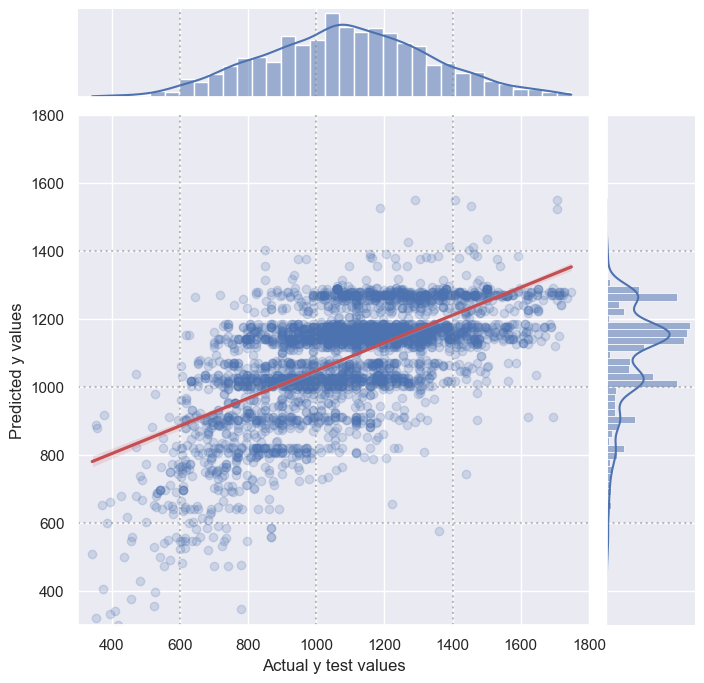

Model R squared: 0.4235
Prediction R squared: 0.3916 p-value: 0.0000
y = 0.4068x +641.7


In [44]:
create_scatter(y_test=y_test_step, y_pred=y_pred_step, model_corr=OLS_model_step.rsquared)

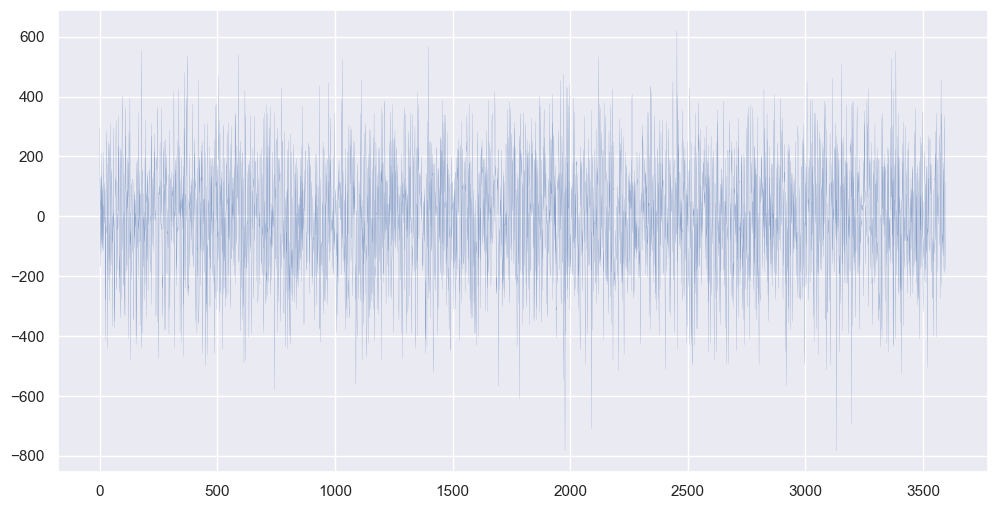

Residuals mean: -3.552162; Standard Deviation: 193.86
 Durbin Watson: 2.05


In [45]:
# Plotting the residuals
residuals_OLS_step = comparison_OLS_step.difference.values

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1,1,1)
ax.plot(residuals_OLS_step, linewidth=0.1)
plt.show()
print(f'Residuals mean: {residuals_OLS_step.mean():.6f}; Standard Deviation: {residuals_OLS_step.std():.2f}'
    f'\n Durbin Watson: {durbin_watson(residuals_OLS_step):.2f}')
# closer to 2 means no autocorrelation; 0 or 4 means autocorrelation

NormaltestResult(statistic=21.878431663728428, pvalue=1.7748388553823333e-05)
KstestResult(statistic=0.5058187010646219, pvalue=0.0, statistic_location=3.2498672355379767, statistic_sign=-1)


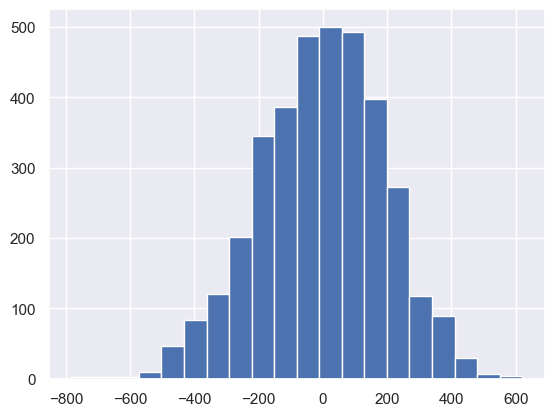

In [46]:
print(normaltest(residuals_OLS_step))
print(kstest(residuals_OLS_step, "norm"))
plt.hist(residuals_OLS_step, bins=20)
plt.show()

# Neural Network

In [47]:
# Create a model and displaying the summary
NN_model = MLPRegressor((X_train.shape[1],X_train.shape[1],X_train.shape[1]), max_iter=2000).fit(X_train, y_train)
# after a few iterations with nodes and depths, this was consistently the best performing model
y_pred_nn = NN_model.predict(X_test)

In [48]:
comparison_nn = pd.DataFrame((y_pred_nn, y_test.values, y_pred_nn - y_test.values)).transpose()
comparison_nn.columns = ["predicted", "test_actuals", "difference"]
comparison_nn.describe()

,predicted,test_actuals,difference
count,3596.000000,3596.000000,3596.000000
mean,1086.627096,1087.816699,-1.189603
std,151.263775,248.445245,193.177499
min,475.474178,342.212740,-786.124267
25%,1020.540438,922.394471,-132.041047
50%,1138.231262,1084.175897,12.385819
75%,1182.092268,1254.112865,134.536813
max,1430.708784,1748.580513,655.468124


Scatter plot of Predicted vs Actual values


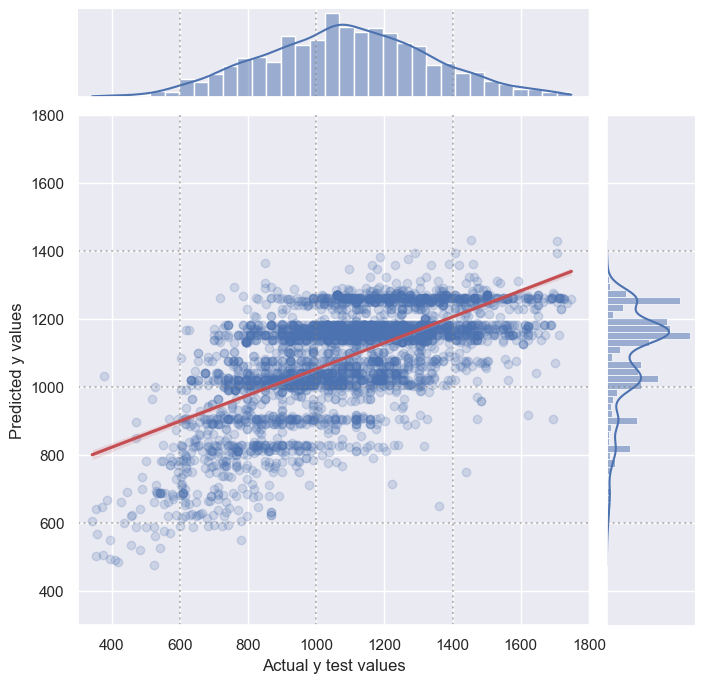

Model R squared: 0.3954
Prediction R squared: 0.3958 p-value: 0.0000
y = 0.3831x +669.9


In [49]:
create_scatter(y_pred=y_pred_nn, model_corr=NN_model.score(X_test, y_test))

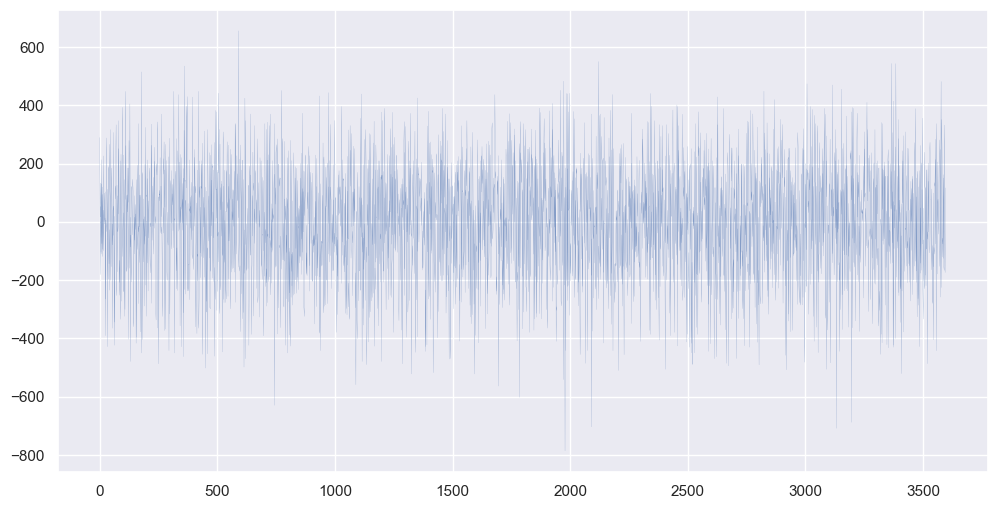

Residuals mean: -1.189603; Standard Deviation: 193.15
 Durbin Watson: 2.06


In [50]:
# Plotting the residuals
residuals_nn = comparison_nn.difference.values

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1,1,1)
ax.plot(residuals_nn, linewidth=0.1)
plt.show()
print(f'Residuals mean: {residuals_nn.mean():.6f}; Standard Deviation: {residuals_nn.std():.2f}'
    f'\n Durbin Watson: {durbin_watson(residuals_nn):.2f}')
# closer to 2 means no autocorrelation; 0 or 4 means autocorrelation

NormaltestResult(statistic=37.044935432288916, pvalue=9.032219425663224e-09)
KstestResult(statistic=0.5159243156311314, pvalue=0.0, statistic_location=2.855076383910273, statistic_sign=-1)


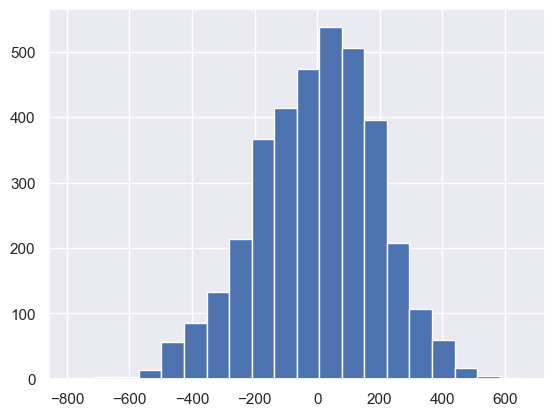

In [51]:
print(normaltest(residuals_nn))
print(kstest(residuals_nn, "norm"))
plt.hist(residuals_nn, bins=20)
plt.show()

# PCA

In [52]:
X_train = X_train.drop('const', axis=1)
X_test = X_test.drop('const', axis=1)

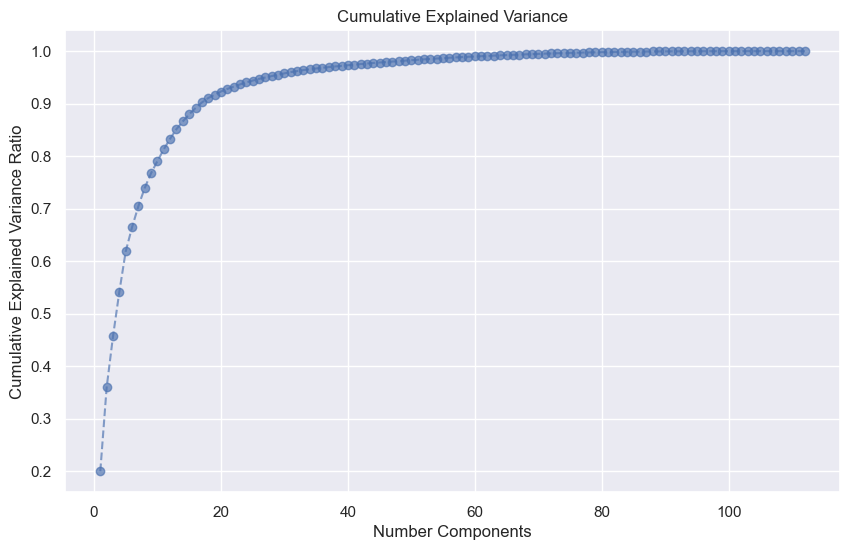

In [53]:
pca = PCA(n_components=X_train.shape[1]).fit(X_train) # fitted on train base only
X_pca_train = pca.transform(X_train) # Transforming train base
X_pca_test = pca.transform(X_test)   # Transforming test base

# Variance explained by each principal component
cumulative_variance_ratio = pca.explained_variance_ratio_.cumsum()

# Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, X_pca_train.shape[1] + 1), cumulative_variance_ratio, marker='o', linestyle='--', alpha=0.67)
plt.title('Cumulative Explained Variance')
plt.xlabel('Number Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

In [54]:
# Print the explained variance ratio for each component

pca_variance = pd.DataFrame({
    'Variance': pca.explained_variance_ratio_,
    'Cumulative Variance': pca.explained_variance_ratio_.cumsum(),
    'Eigenvalue': pca.singular_values_
    })
pca_variance['Component'] = pca_variance.index +1

pca_variance['Component'] = 'PC' + pca_variance['Component'].astype(str)
print(pca_variance[pca_variance.Eigenvalue >= 1].to_string())
print(pca_variance[pca_variance.Eigenvalue < 1].to_string())

    Variance  Cumulative Variance  Eigenvalue Component
0   0.200147             0.200147   72.504574       PC1
1   0.159496             0.359644   64.724060       PC2
2   0.097140             0.456784   50.511485       PC3
3   0.085145             0.541929   47.290056       PC4
4   0.076615             0.618544   44.858730       PC5
5   0.046062             0.664606   34.782642       PC6
6   0.040271             0.704877   32.522873       PC7
7   0.034713             0.739591   30.195320       PC8
8   0.028029             0.767620   27.132932       PC9
9   0.023156             0.790776   24.661821      PC10
10  0.022292             0.813068   24.196993      PC11
11  0.020198             0.833266   23.032523      PC12
12  0.018217             0.851483   21.874168      PC13
13  0.014794             0.866277   19.712335      PC14
14  0.013498             0.879775   18.829039      PC15
15  0.011862             0.891637   17.650879      PC16
16  0.010662             0.902300   16.734697   

In [55]:
components_df = pd.DataFrame(pca.components_, columns=X_train.columns).set_index(pca_variance['Component'])
components_df

,work_year,work_abroad,job_name_AI,job_name_Analyst,job_name_Analytics,job_name_Applied,job_name_Architect,job_name_Big,job_name_Consultant,job_name_Database,...,company_location_MX,company_location_NG,company_location_NL,company_location_PL,company_location_PT,company_location_SI,company_location_UA,company_location_ZA,company_size_L,company_size_S
Component,,,,,,,,,,,,,,,,,,,,,
PC1,-0.970251,9.815389e-03,-6.247463e-03,-1.200271e-02,8.223692e-05,1.507287e-03,-2.039085e-03,2.396964e-03,-9.062365e-04,-9.243776e-04,...,6.205019e-04,1.208472e-03,1.843930e-03,1.658818e-04,2.810537e-03,0.000976,-0.000354,-0.001717,7.359063e-02,2.337990e-02
PC2,-0.028375,1.139406e-03,-7.224876e-03,1.218337e-01,-4.596577e-02,5.580290e-02,9.715429e-03,-8.472181e-04,1.064042e-02,-1.489072e-03,...,-6.048745e-04,2.191027e-04,7.359008e-04,5.199360e-04,-1.168900e-03,-0.000263,-0.000481,-0.000766,4.141749e-02,1.645637e-03
PC3,0.032136,-3.477433e-05,-2.613383e-03,6.959865e-01,-2.233260e-03,-5.512599e-02,2.414961e-02,6.034318e-04,-9.608631e-03,3.432701e-05,...,-1.286238e-04,1.288876e-03,-4.752738e-04,5.888301e-04,6.272282e-04,0.000574,-0.000282,0.000540,-6.081271e-02,4.679181e-03
PC4,-0.200828,-4.076625e-03,-3.016267e-03,1.890787e-01,-1.653086e-02,-1.096247e-02,-1.978640e-02,1.125331e-03,9.726378e-04,-1.100737e-03,...,-1.469968e-03,-4.246620e-04,1.901280e-03,-1.794555e-03,1.223447e-03,0.000904,-0.000456,0.001690,6.301650e-02,-4.906760e-04
PC5,0.035569,3.742007e-03,2.504383e-03,-1.342766e-01,3.365014e-02,3.601654e-03,-1.947701e-02,1.231867e-03,8.336085e-05,2.434931e-03,...,1.329262e-03,-3.595582e-05,2.002886e-03,8.345315e-05,1.113928e-03,0.001643,-0.000777,0.000206,1.954288e-02,6.156257e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PC108,0.000000,6.923746e-17,-7.456339e-18,-1.455468e-17,3.902327e-18,5.583306e-18,-3.697599e-17,-5.506458e-17,2.755094e-17,-2.761164e-16,...,-3.588194e-16,-2.427231e-16,-7.000513e-17,-1.740482e-16,1.517708e-16,0.390050,0.139040,-0.319525,1.759797e-18,-5.974793e-17
PC109,0.000000,-6.238026e-17,3.075487e-17,2.936954e-17,-1.800242e-19,1.333885e-17,1.440334e-17,-1.596332e-16,-7.613989e-18,-2.248005e-16,...,-3.771041e-16,-7.858944e-17,-4.308127e-16,-9.849336e-17,-1.270741e-16,0.001090,-0.087771,-0.128993,3.080237e-18,6.101426e-17
PC110,0.000000,5.670875e-18,-3.537759e-18,-4.485629e-17,-5.865450e-18,1.331193e-17,-6.697587e-17,-2.352774e-17,-4.837992e-17,3.762268e-16,...,1.542567e-16,-2.509204e-16,4.023663e-16,-2.399362e-16,1.466252e-17,0.041782,0.239760,-0.382876,2.559141e-18,-7.925680e-18


In [56]:
# How many components have Eigenvalues larger than 1?
Eigen1 = pca_variance[pca_variance.Eigenvalue >= 1].shape[0]
Eigen1

95

In [75]:
pca_variance['Labels'] = pca_variance['Component'] + ":\n" + (pca_variance['Cumulative Variance']*100).round(1).astype(str) + '%'
pca_variance.tail(20)

,Variance,Cumulative Variance,Eigenvalue,Component,Labels
92,5.755506e-05,0.999764,1.229510e+00,PC93,PC93:\n100.0%
93,4.565911e-05,0.999809,1.095101e+00,PC94,PC94:\n100.0%
94,4.197834e-05,0.999851,1.050033e+00,PC95,PC95:\n100.0%
95,3.212980e-05,0.999884,9.186382e-01,PC96,PC96:\n100.0%
96,2.932422e-05,0.999913,8.776144e-01,PC97,PC97:\n100.0%
97,2.532226e-05,0.999938,8.155334e-01,PC98,PC98:\n100.0%
98,2.147496e-05,0.999960,7.510288e-01,PC99,PC99:\n100.0%
99,1.426990e-05,0.999974,6.122107e-01,PC100,PC100:\n100.0%
100,1.078421e-05,0.999985,5.322119e-01,PC101,PC101:\n100.0%
101,8.800883e-06,0.999994,4.807880e-01,PC102,PC102:\n100.0%


## Creating a PCA visualization plot
The main reason here is to understand each component's relation to the original variables

In [58]:
# Set cumulative variance milestones for the chart
reference_y_values = [.90, .95, .975, .99, .995, .999]
y_ticks = []
for val in reference_y_values:
    aux = pca_variance[pca_variance['Cumulative Variance'] > val]
    aux = aux.iloc[0, :]
    y_ticks.append(aux.name)
y_ticks

[16, 27, 41, 60, 70, 84]

In [59]:
# Count independent variables in categories to ease visualization
aux = []
for col in X_train.columns:
    aux.append(col[:9])
unique_entries = {}
for entry in set(aux):
    unique_entries[entry] = 0
for entry in aux:
    unique_entries[entry] = unique_entries[entry] + 1
unique_entries

{'employmen': 3,
 'work_year': 1,
 'company_l': 26,
 'job_name_': 43,
 'salary_cu': 5,
 'experienc': 3,
 'work_abro': 1,
 'employee_': 26,
 'remote_ra': 2,
 'company_s': 2}

In [60]:
# Set the limit for each new variables' category
limit_x_values = [1, 2, unique_entries['job_name_'] + 2]
for aux in ['experienc', 'employmen', 'salary_cu', 'employee_', 'remote_ra', 'company_l', 'company_s']:
    limit_x_values.append(max(limit_x_values) + unique_entries[aux])
del limit_x_values[-1:] #removing the last value as it's out of bounds for the DataFrame
print(limit_x_values)
[X_train.columns[i] for i in limit_x_values]

[1, 2, 45, 48, 51, 56, 82, 84, 110]


['work_abroad',
 'job_name_AI',
 'experience_level_EN',
 'employment_type_CT',
 'salary_currency_AUD',
 'employee_residence_AR',
 'remote_ratio_Hybrid',
 'company_location_AR',
 'company_size_L']

In [61]:
# based on the variable limits, position the ticks for a few variables for readability
xticks = [1, # work abroad
 round((limit_x_values[1] + limit_x_values[2])/2), # Job title in the middle
 limit_x_values[2],            # Experience level on one corner (will overlap with employment type, so that'll be skipped)
 limit_x_values[5]-1,                              # Currency on the other corner
 round((limit_x_values[5] + limit_x_values[7])/2), # Employee residence (middle)
 limit_x_values[7]-1,                              # Remote Ratio (middle)
 round(sum(limit_x_values[7:9])/2),                # Company Location (middle)
 limit_x_values[8]]                                # Company Size (middle)
[X_train.columns[i] for i in xticks]               # Review which variables will show

['work_abroad',
 'job_name_Principal',
 'experience_level_EN',
 'salary_currency_INR',
 'employee_residence_IN',
 'remote_ratio_Remote',
 'company_location_IE',
 'company_size_L']

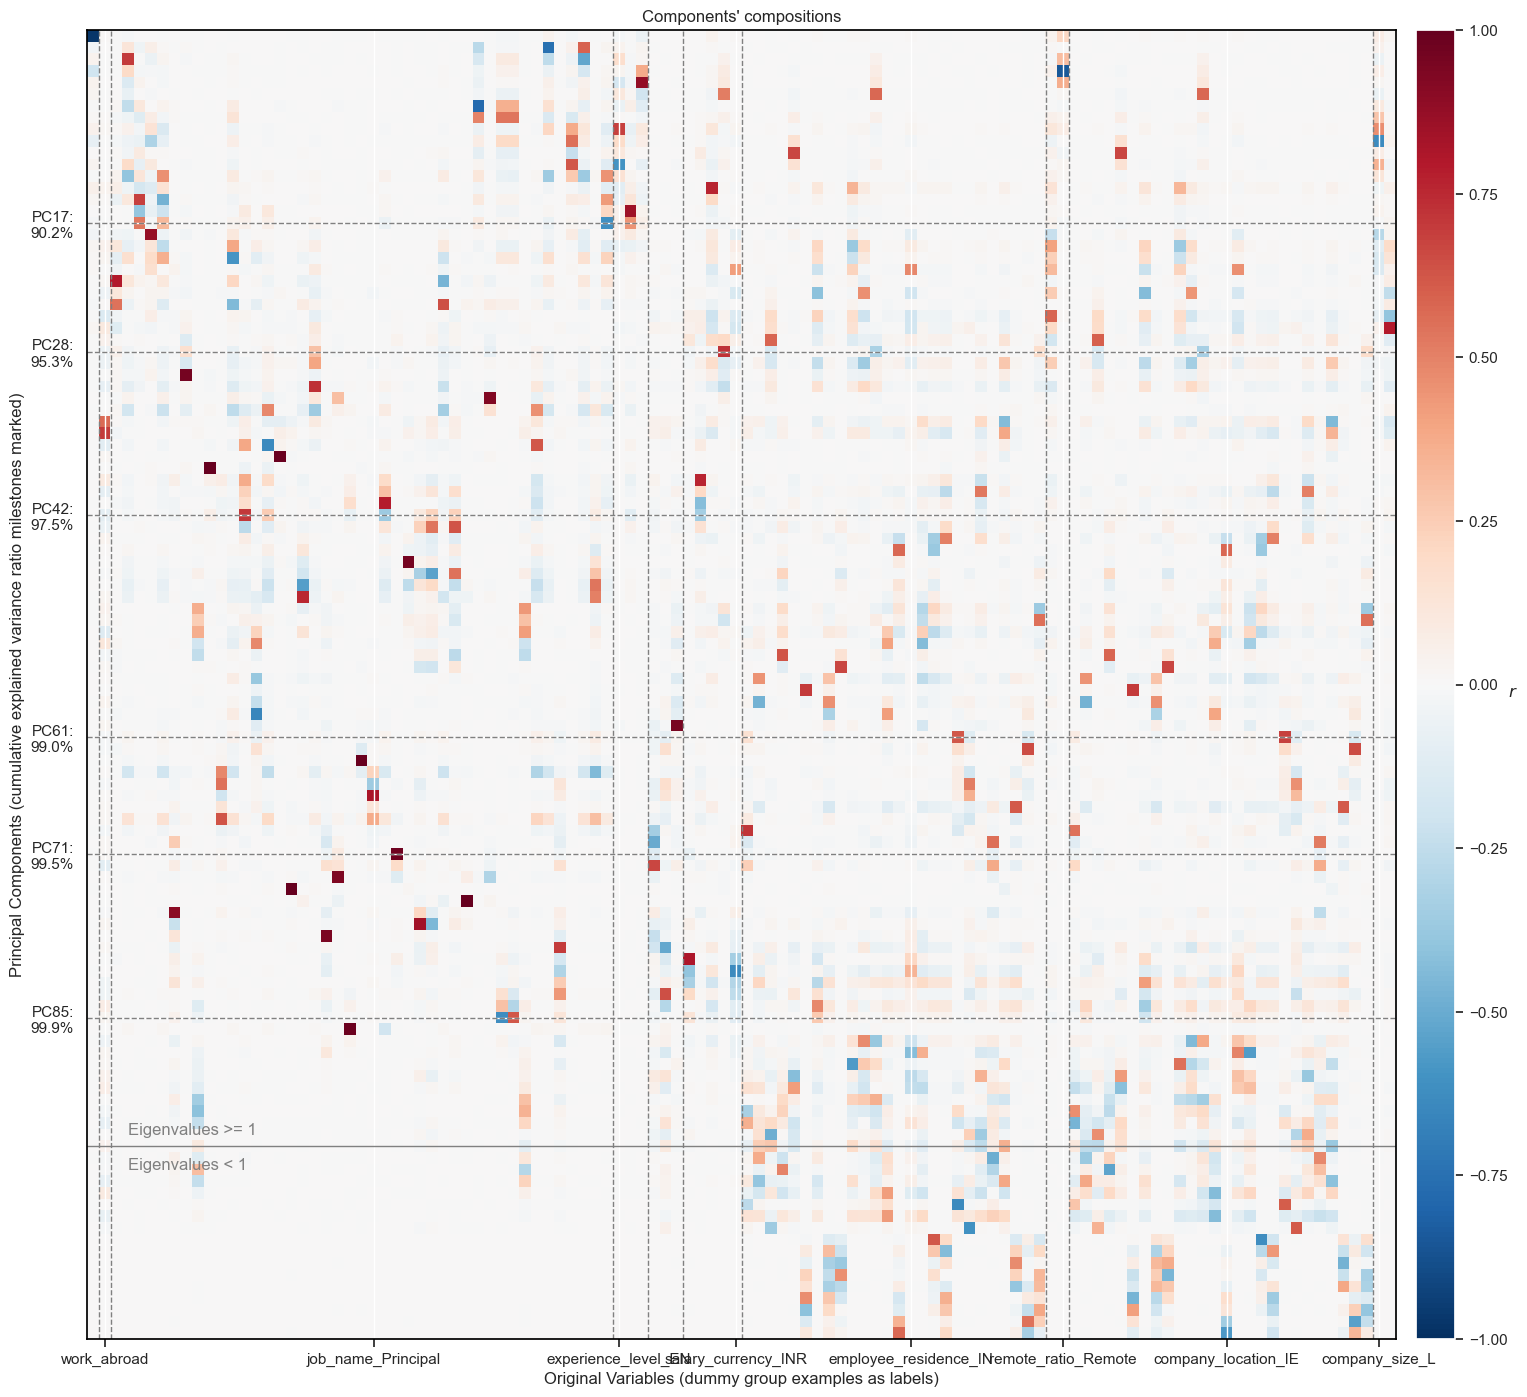

In [62]:
# Components' compositions heat matrix plot

fig, ax = plt.subplots(figsize=(18, 17))
im = ax.imshow(components_df, cmap="RdBu_r", vmin=-1, vmax=1)
ax.set_title("Components' compositions")
plt.xlabel('Original Variables (dummy group examples as labels)')
plt.ylabel('Principal Components (cumulative explained variance ratio milestones marked)')

ax.tick_params(left=False, right=False, top=False, reset=True)
ax.set_xticks(xticks)
ax.set_xticklabels(components_df.columns[xticks])
for x_value in limit_x_values:
    plt.axvline(x=x_value-0.5, color='gray', linestyle='--', linewidth=1)

ax.set_yticks(y_ticks)
ax.set_yticklabels(pca_variance['Labels'][y_ticks])
for y_value in y_ticks:
    plt.axhline(y=y_value, color='gray', linestyle='--', linewidth=1)
    
plt.axhline(y=Eigen1, color='gray', linestyle='-', linewidth=1)
plt.annotate('Eigenvalues >= 1', xy=(0, Eigen1), xytext=(3, Eigen1-1), color="gray", size=12)
plt.annotate('Eigenvalues < 1', xy=(0, Eigen1), xytext=(3, Eigen1+2), color="gray", size=12)

cax = make_axes_locatable(ax).append_axes("right", size="3%", pad=0.2)
plt.colorbar(im, cax=cax).ax.set_ylabel("$r$", rotation=0)

[a.set_color("black") for a in ax.spines.values()]

plt.show()

In [63]:
# The naming used here is X_pca will be the original array and X_train_pca will be the dataframe derived from it
X_train_pca = pd.DataFrame(X_pca_train, columns = pca_variance['Component'].to_list())
X_train_pca.set_index(X_train.index, inplace=True)
X_train_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC103,PC104,PC105,PC106,PC107,PC108,PC109,PC110,PC111,PC112
8126,0.015089,0.746815,-0.456698,0.441183,0.589518,-0.180421,-0.095800,-0.063914,-0.060492,0.099260,...,0.000069,-3.437050e-18,1.972624e-18,-5.733277e-20,9.435869e-18,-4.720372e-18,-2.897814e-18,3.897146e-18,1.519584e-18,-5.220038e-18
11729,0.311179,-0.617593,0.094903,-0.666556,0.079495,0.008818,0.238074,-0.194535,0.013644,-0.036106,...,0.000035,-7.014917e-18,-3.394176e-18,6.176830e-18,2.713815e-18,2.652203e-18,2.414777e-18,1.286892e-17,1.248533e-18,6.055664e-18
1698,-0.923337,-0.612955,-0.158362,0.307920,0.625212,-0.238909,0.093080,-0.120849,0.051019,0.260842,...,0.000049,-5.388614e-18,-1.645881e-17,2.870013e-18,1.225479e-17,2.218522e-18,5.342123e-18,3.474270e-17,3.742198e-18,-4.162941e-18
761,-0.864282,-0.639696,-0.178719,-0.019544,-0.250482,0.009792,0.251722,-0.219961,-0.016070,-0.117022,...,0.000221,-1.005068e-17,-1.008932e-18,6.014199e-18,2.063294e-18,3.519565e-18,-4.041488e-19,7.014227e-18,3.091677e-18,5.730404e-18
8772,0.105968,-0.611321,-0.210855,0.181284,-0.286051,-0.014004,0.255912,-0.232493,-0.061362,-0.038607,...,0.000113,-7.123337e-18,-1.008932e-18,6.014199e-18,2.063294e-18,3.519565e-18,-4.041488e-19,7.014227e-18,3.091677e-18,5.730404e-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5191,0.205082,0.270471,1.065126,-0.049808,0.774314,-0.292926,-0.272730,-0.122111,-0.056087,-0.028643,...,-0.000275,1.293440e-17,-2.689445e-18,4.305582e-19,-9.724720e-19,-7.214037e-18,7.185266e-18,1.698889e-17,-1.707448e-17,4.971462e-18
13418,1.281430,-0.589218,0.062768,-0.465728,0.043925,-0.014978,0.242264,-0.207067,-0.031648,0.042310,...,-0.000073,-4.087571e-18,-3.394176e-18,6.176830e-18,2.713815e-18,2.652203e-18,2.414777e-18,1.286892e-17,1.248533e-18,6.055664e-18
5390,0.105968,-0.611321,-0.210855,0.181284,-0.286051,-0.014004,0.255912,-0.232493,-0.061362,-0.038607,...,0.000113,-7.123337e-18,-1.008932e-18,6.014199e-18,2.063294e-18,3.519565e-18,-4.041488e-19,7.014227e-18,3.091677e-18,5.730404e-18
860,-0.955162,0.718440,-0.424562,0.240355,0.625087,-0.156625,-0.099990,-0.051382,-0.015200,0.020845,...,0.000177,-6.364396e-18,1.972624e-18,-5.733277e-20,9.435869e-18,-4.720372e-18,-2.897814e-18,3.897146e-18,1.519584e-18,-5.220038e-18


In [64]:
X_train_pca.describe()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC103,PC104,PC105,PC106,PC107,PC108,PC109,PC110,PC111,PC112
count,1.083100e+04,1.083100e+04,1.083100e+04,1.083100e+04,1.083100e+04,1.083100e+04,1.083100e+04,1.083100e+04,1.083100e+04,1.083100e+04,...,1.083100e+04,1.083100e+04,1.083100e+04,1.083100e+04,1.083100e+04,1.083100e+04,1.083100e+04,1.083100e+04,1.083100e+04,1.083100e+04
mean,-5.963678e-14,-1.421610e-15,1.953320e-15,-1.221456e-14,2.257471e-15,1.471468e-15,-3.237493e-16,7.826401e-16,2.782374e-15,-4.823766e-15,...,7.192592e-18,-2.418536e-19,9.431493e-20,-2.658291e-19,-3.533691e-19,2.517675e-19,-9.441380e-20,1.666997e-19,-1.026360e-20,-1.043896e-19
std,6.967086e-01,6.219443e-01,4.853733e-01,4.544181e-01,4.310551e-01,3.342322e-01,3.125177e-01,2.901519e-01,2.607249e-01,2.369796e-01,...,3.967687e-03,3.172405e-17,2.764291e-17,2.705265e-17,2.687344e-17,2.685964e-17,3.054144e-17,3.019560e-17,2.694170e-17,2.395748e-17
min,-1.015156e+00,-9.180928e-01,-8.690249e-01,-1.025668e+00,-6.897424e-01,-5.283050e-01,-9.371671e-01,-4.121798e-01,-4.830577e-01,-9.814853e-01,...,-2.071738e-01,-4.772471e-16,-3.396859e-16,-4.322073e-16,-3.858578e-16,-5.364673e-16,-4.294222e-16,-3.404071e-16,-2.799393e-16,-3.040203e-16
25%,-7.070242e-01,-6.150667e-01,-3.748813e-01,-3.937053e-01,-3.069165e-01,-1.271093e-01,-1.462756e-01,-1.945349e-01,-1.506432e-01,-9.769621e-02,...,-1.190883e-04,-7.231758e-18,-3.394176e-18,-1.575216e-18,-4.441919e-18,-5.370893e-18,-5.825160e-18,-6.755141e-18,-1.046085e-17,-5.220038e-18
50%,7.323265e-02,1.691274e-01,-1.736948e-01,9.268361e-02,-2.383746e-01,-1.668941e-02,1.874412e-02,-6.406481e-02,-6.136177e-02,-1.856569e-02,...,1.786168e-05,-3.220210e-18,9.426323e-19,8.100290e-19,2.063294e-18,3.519565e-18,-4.041488e-19,1.159535e-18,2.441156e-18,1.176755e-18
75%,2.632264e-01,7.166690e-01,1.267363e-01,2.772367e-01,1.194024e-01,1.442387e-02,2.225808e-01,4.984538e-02,3.319461e-02,3.980898e-02,...,1.133687e-04,8.922855e-18,3.761558e-18,6.014199e-18,4.665379e-18,5.254288e-18,4.366341e-18,9.751837e-18,5.639552e-18,5.730404e-18
max,3.295522e+00,9.350635e-01,1.418940e+00,1.539626e+00,1.333064e+00,1.805275e+00,1.068234e+00,1.405416e+00,1.652814e+00,1.130115e+00,...,3.270468e-01,4.781927e-16,3.205112e-16,4.334772e-16,3.921656e-16,3.515485e-16,5.256507e-16,5.973352e-16,2.715564e-16,2.596092e-16


In [65]:
#Applying the same transformation to the test base
X_test_pca = pd.DataFrame(X_pca_test, columns = pca_variance['Component'].to_list())
X_test_pca.set_index(X_test.index, inplace=True)

# PCA Model

### Only those with eigenvalues > 1 are selected

In [66]:
components = X_train_pca.columns[:Eigen1]
X_train_eigen1 = X_train_pca[components]
X_train_eigen1 = sm.add_constant(X_train_eigen1)
X_test_eigen1 = X_test_pca[components]
X_test_eigen1 = sm.add_constant(X_test_eigen1)

In [67]:
# Create a model with PCA cols
OLS_model_PCA = sm.OLS(y_train, X_train_eigen1).fit()
OLS_model_PCA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     transformed_salary   R-squared:                       0.434
Model:                            OLS   Adj. R-squared:                  0.429
Method:                 Least Squares   F-statistic:                     86.76
Date:                Sun, 24 Mar 2024   Prob (F-statistic):               0.00
Time:                        20:26:56   Log-Likelihood:                -72074.
No. Observations:               10831   AIC:                         1.443e+05
Df Residuals:                   10735   BIC:                         1.450e+05
Df Model:                          95                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1084.7585      1.813    598.399      0.000    1081.205    1088.312
PC1          -22.0111      2.602     -8.459      0.000     -27.112     -16.911
PC2          -37.5088      2.915    -12.868      0.000     -43.222     -31.795
PC3         -193.0437      3.735    -51.686      0.000    -200.365    -185.722
PC4         -116.0787      3.989    -29.097      0.000    -123.899    -108.259
PC5         -105.8116      4.206    -25.160      0.000    -114.055     -97.568
PC6          -99.7514      5.424    -18.391      0.000    -110.383     -89.119
PC7          -34.0669      5.801     -5.873      0.000     -45.437     -22.696
PC8            5.7365      6.248      0.918      0.359      -6.511      17.984
PC9         -172.5151      6.953    -24.811      0.000    -186.145    -158.886
PC10          -6.7122      7.650     -0.877      0.380     -21.707       8.283
PC11         -67.1377      7.797     -8.611      0.000     -82.421     -51.855
PC12         196.5638      8.191     23.998      0.000     180.508     212.620
PC13          10.0014      8.625      1.160      0.246      -6.905      26.907
PC14        -281.6622      9.571    -29.430      0.000    -300.422    -262.902
PC15         -45.9226     10.020     -4.583      0.000     -65.563     -26.282
PC16          90.6852     10.688      8.484      0.000      69.734     111.636
PC17          98.9010     11.274      8.773      0.000      76.803     120.999
PC18         108.9084     12.693      8.580      0.000      84.027     133.789
PC19        -101.7876     14.591     -6.976      0.000    -130.388     -73.187
PC20         103.9132     14.937      6.957      0.000      74.634     133.193
PC21        -230.3591     16.646    -13.838      0.000    -262.989    -197.729
PC22         137.4299     17.445      7.878      0.000     103.235     171.625
PC23         100.0131     18.092      5.528      0.000      64.549     135.477
PC24          -6.1001     18.524     -0.329      0.742     -42.410      30.210
PC25         134.0430     20.160      6.649      0.000      94.526     173.560
PC26         -16.5723     20.449     -0.810      0.418     -56.655      23.511
PC27         -83.5674     22.192     -3.766      0.000    -127.067     -40.068
PC28        -193.2142     22.409     -8.622      0.000    -237.141    -149.288
PC29          49.9242     22.878      2.182      0.029       5.079      94.770
PC30        -163.5010     22.980     -7.115      0.000    -208.545    -118.457
PC31         223.8624     24.214      9.245      0.000     176.398     271.327
PC32        -106.8781     25.650     -4.167      0.000    -157.156     -56.600
PC33          43.1481     27.053      1.595      0.111      -9.880      96.176
PC34          32.4483     29.178      1.112      0.266     -24.745      89.642
PC35         -29.6619     29.824     -0.995      0.320     -88.122      28.799
PC

In [68]:
y_pred_eigen1 = OLS_model_PCA.predict(X_test_eigen1)

In [69]:
comparison_eigen1 = y_pred_eigen1.to_frame().join(y_test.to_frame()).join((y_pred_eigen1 - y_test).to_frame(), lsuffix='pred')
comparison_eigen1.columns = ["predicted", "test_actuals", "difference"]
comparison_eigen1.describe()

,predicted,test_actuals,difference
count,3596.000000,3596.000000,3596.000000
mean,1084.283781,1087.816699,-3.532918
std,162.435180,248.445245,192.237704
min,334.782639,342.212740,-783.920703
25%,1009.415418,922.394471,-130.844656
50%,1135.563993,1084.175897,7.048152
75%,1177.974329,1254.112865,131.794808
max,1541.772774,1748.580513,652.293204


Scatter plot of Predicted vs Actual values


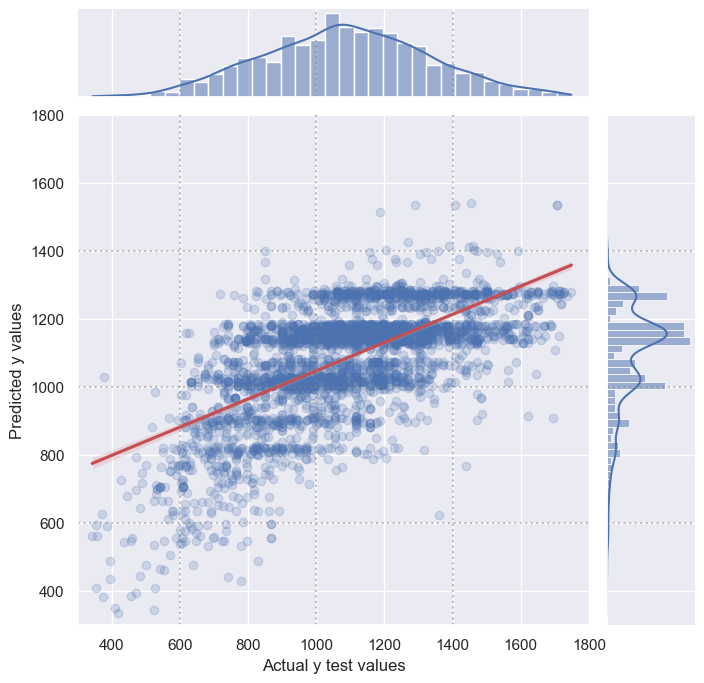

Model R squared: 0.4343
Prediction R squared: 0.4017 p-value: 0.0000
y = 0.4144x +633.5


In [70]:
create_scatter(y_pred=y_pred_eigen1, model_corr=OLS_model_PCA.rsquared)

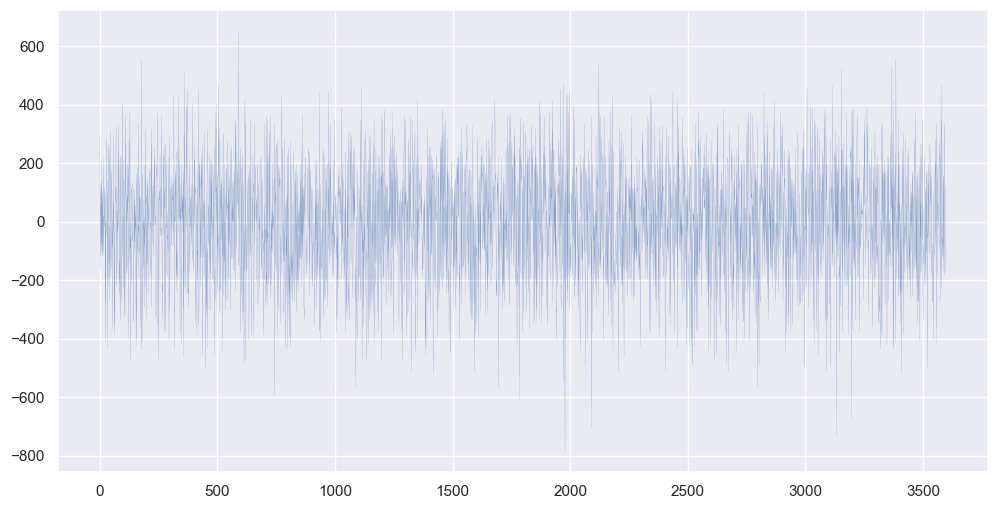

Residuals mean: -3.532918; Standard Deviation: 192.21
 Durbin Watson: 2.05


In [71]:
# Plotting the residuals
residuals_OLS_PCA = comparison_eigen1.difference.values

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1,1,1)
ax.plot(residuals_OLS_PCA, linewidth=0.1)
plt.show()
print(f'Residuals mean: {residuals_OLS_PCA.mean():.6f}; Standard Deviation: {residuals_OLS_PCA.std():.2f}'
    f'\n Durbin Watson: {durbin_watson(residuals_OLS_PCA):.2f}')
# closer to 2 means no autocorrelation; 0 or 4 means autocorrelation

NormaltestResult(statistic=29.7537172471322, pvalue=3.459890798319453e-07)
KstestResult(statistic=0.5077279483685041, pvalue=0.0, statistic_location=3.8524078571797418, statistic_sign=-1)


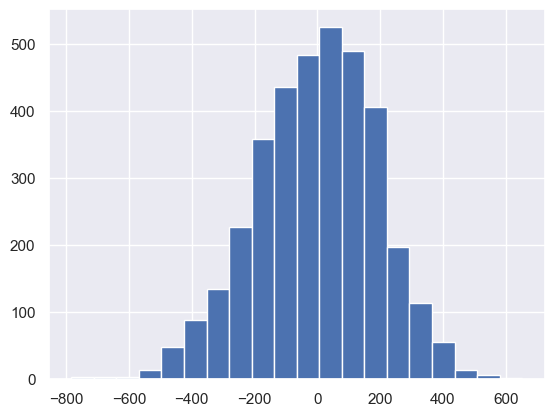

In [72]:
# tests and histogram to look at residuals' normality
print(normaltest(residuals_OLS_PCA))
print(kstest(residuals_OLS_PCA, "norm"))
plt.hist(residuals_OLS_PCA, bins=20)
plt.show()